In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# functions needed for pr_auc_score()
from sklearn.metrics import auc, precision_recall_curve

# functions needed for imbalanced_cross_validation_score()
from sklearn.model_selection import StratifiedKFold

# sampler objects
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Classification models to compare
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
# load data
df = pd.read_csv("creditcard.csv")
A  = df.values
x  = A[:,:-1]     
y  = A[:,-1]

In [34]:
print(df.columns[-1])
df.iloc[:6, :6]


Class


,Time,V1,V2,V3,V4,V5
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987


In [12]:
df.shape

(284807, 31)

In [15]:
print(df.values.shape)
df.values


(284807, 31)


array([[ 0.00000000e+00, -1.35980713e+00, -7.27811733e-02, ...,
        -2.10530535e-02,  1.49620000e+02,  0.00000000e+00],
       [ 0.00000000e+00,  1.19185711e+00,  2.66150712e-01, ...,
         1.47241692e-02,  2.69000000e+00,  0.00000000e+00],
       [ 1.00000000e+00, -1.35835406e+00, -1.34016307e+00, ...,
        -5.97518406e-02,  3.78660000e+02,  0.00000000e+00],
       ...,
       [ 1.72788000e+05,  1.91956501e+00, -3.01253846e-01, ...,
        -2.65608286e-02,  6.78800000e+01,  0.00000000e+00],
       [ 1.72788000e+05, -2.40440050e-01,  5.30482513e-01, ...,
         1.04532821e-01,  1.00000000e+01,  0.00000000e+00],
       [ 1.72792000e+05, -5.33412522e-01, -1.89733337e-01, ...,
         1.36489143e-02,  2.17000000e+02,  0.00000000e+00]])

In [32]:
print(type(A[:,-1]))
np.unique(A[:,-1])

<class 'numpy.ndarray'>


array([0., 1.])

In [36]:
def pr_auc_score(clf, x, y):
    '''
        This function computes area under the precision-recall curve. 
    '''
      
    precisions, recalls,_ = precision_recall_curve(y, clf.predict_proba(x)[:,1], pos_label=1)
    
    return auc(recalls, precisions) 

In [48]:
def imbalanced_cross_validation_score(clf, x, y, cv, scoring, sampler):
    '''
        This function computes the cross-validation score of a given 
        classifier using a choice of sampling function to mitigate 
        the class imbalance, and stratified k-fold sampling.
        
        The first five arguments are the same as 
        sklearn.model_selection.cross_val_score.
        
        - clf.predict_proba(x) returns class label probabilities
        - clf.fit(x,y) trains the model
        
        - x = data
        
        - y = labels
        
        - cv = the number of folds in the cross validation
        
        - scoring(classifier, x, y) returns a float
        
        The last argument is a choice of random sampler: an object 
        similar to the sampler objects available from the python 
        package imbalanced-learn. In particular, this 
        object needs to have the method:
        
        sampler.fit_resample(x,y)
        
        See http://contrib.scikit-learn.org/imbalanced-learn/
        for more details and examples of other sampling objects 
        available.  
    
    '''
    
    cv_score = 0.
    train_score = 0.
    test_score = 0.
    
    # stratified k-fold creates folds with the same ratio of positive 
    # and negative samples as the entire dataset.
    
    skf = StratifiedKFold(n_splits=cv, shuffle=False)
    
    for train_idx, test_idx in skf.split(x,y):
        
        xfold_train_sampled, yfold_train_sampled = sampler.fit_resample(x[train_idx],y[train_idx])
        clf.fit(xfold_train_sampled, yfold_train_sampled)
        
        train_score = scoring(clf, xfold_train_sampled, yfold_train_sampled)
        test_score  = scoring(clf, x[test_idx], y[test_idx])
        
        print("Train AUPRC: %.2f Test AUPRC: %.2f"%(train_score,test_score))

        cv_score += test_score
        
    return cv_score/cv

Let's compare several basic models with different types of over/under sampling. We will use:
RandomOverSampler()

SMOTE()

We use 5-fold validation for all our tests, for the sake of speed.

In [49]:
cv = 5  
RegressionModel    = LogisticRegression()


In [50]:
# Logistic regression score with Random Over-sampling
print("Random over-sampling")
ROS = RandomOverSampler()
score = imbalanced_cross_validation_score(RegressionModel, x, y, cv, pr_auc_score, ROS)
print("Cross-validated AUPRC score: %.2f"%score)

# Logistic regression score with SMOTE
print("SMOTE over-sampling")
SMT = SMOTE()
score = imbalanced_cross_validation_score(RegressionModel, x, y, cv, pr_auc_score, SMT)
print("Cross-validated AUPRC score: %.2f"%score)

Random over-sampling
Train AUPRC: 0.98 Test AUPRC: 0.69
Train AUPRC: 0.98 Test AUPRC: 0.83
Train AUPRC: 0.99 Test AUPRC: 0.67
Train AUPRC: 0.98 Test AUPRC: 0.86
Train AUPRC: 0.98 Test AUPRC: 0.71
Cross-validated AUPRC score: 0.75
SMOTE over-sampling


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train AUPRC: 1.00 Test AUPRC: 0.72
Train AUPRC: 0.99 Test AUPRC: 0.84
Train AUPRC: 0.99 Test AUPRC: 0.65


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train AUPRC: 0.99 Test AUPRC: 0.88
Train AUPRC: 0.99 Test AUPRC: 0.75
Cross-validated AUPRC score: 0.77


In [52]:
# for fun, let's plot one of the precision-recall curves that is computed above
sampler = SMOTE()
skf = StratifiedKFold(n_splits=cv, shuffle=False)
clf = RegressionModel
train_idx, test_idx = skf.split(x,y).__next__()  #without next, too many values to unpack
xfold_train_sampled, yfold_train_sampled = sampler.fit_resample(x[train_idx], y[train_idx])

In [53]:
clf.fit(xfold_train_sampled, yfold_train_sampled)

LogisticRegression()

In [55]:
precisions,recalls,_ = precision_recall_curve(y[test_idx], clf.predict_proba(x[test_idx])[:,1], pos_label=1)

Text(0.5, 1.0, 'Precision-Recall curve')

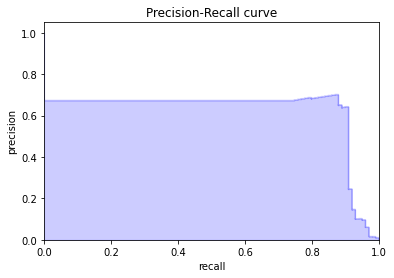

In [56]:
plt.step(recalls, precisions,color='b', alpha=0.2, where="post")
plt.fill_between(recalls, precisions, step='post', alpha=0.2,
                 color='b')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')